In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import warnings
import re
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AirlineCustSatis.csv')

In [3]:
# format columns name
def format_column_names(df):
    """
    Format all column names in a DataFrame to snake_case.

    Parameters:
        df (pandas.DataFrame): DataFrame whose column names are to be formatted.

    Returns:
        pandas.DataFrame: DataFrame with column names formatted to snake_case.
    """
    formatted_columns = [col.replace(' ', '_').lower() for col in df.columns]
    df.columns = formatted_columns
    return df

In [4]:
df = format_column_names(df)

In [5]:
df.head()

,satisfaction,gender,customer_type,age,type_of_travel,class,flight_distance,seat_comfort,departure/arrival_time_convenient,food_and_drink,...,online_support,ease_of_online_booking,on-board_service,leg_room_service,baggage_handling,checkin_service,cleanliness,online_boarding,departure_delay_in_minutes,arrival_delay_in_minutes
0,0,Male,Loyal Customer,48,Personal Travel,Eco Plus,1201,1,0,0,...,5,5,5,5,4,4,5,5,0,0.0
1,0,Male,Loyal Customer,30,Personal Travel,Eco,1582,1,0,0,...,1,1,2,4,3,5,1,1,0,2.0
2,0,Male,Loyal Customer,19,Personal Travel,Eco,1737,1,0,0,...,1,1,4,4,5,3,5,1,0,0.0
3,0,Male,Loyal Customer,13,Personal Travel,Eco,1351,1,0,0,...,5,5,5,2,5,4,4,5,4,2.0
4,0,Male,Loyal Customer,31,Personal Travel,Eco,1109,1,0,0,...,4,4,3,3,4,3,4,4,0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15190 entries, 0 to 15189
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   satisfaction                       15190 non-null  int64  
 1   gender                             15190 non-null  object 
 2   customer_type                      15190 non-null  object 
 3   age                                15190 non-null  int64  
 4   type_of_travel                     15190 non-null  object 
 5   class                              15190 non-null  object 
 6   flight_distance                    15190 non-null  int64  
 7   seat_comfort                       15190 non-null  int64  
 8   departure/arrival_time_convenient  15190 non-null  int64  
 9   food_and_drink                     15190 non-null  int64  
 10  gate_location                      15190 non-null  int64  
 11  inflight_wifi_service              15190 non-null  int

In [7]:
df.dropna(inplace = True)

In [8]:
df.apply(lambda col: col.unique())

satisfaction                                                                    [0, 1]
gender                                                                  [Male, Female]
customer_type                                      [Loyal Customer, disloyal Customer]
age                                  [48, 30, 19, 13, 31, 60, 70, 25, 47, 24, 29, 3...
type_of_travel                                      [Personal Travel, Business travel]
class                                                        [Eco Plus, Eco, Business]
flight_distance                      [1201, 1582, 1737, 1351, 1109, 3434, 2193, 235...
seat_comfort                                                        [1, 2, 4, 3, 5, 0]
departure/arrival_time_convenient                                   [0, 1, 2, 3, 4, 5]
food_and_drink                                                      [0, 1, 2, 3, 4, 5]
gate_location                                                       [1, 3, 4, 2, 5, 0]
inflight_wifi_service                      

# EDA

In [9]:
numerical_columns = ['age','flight_distance','departure_delay_in_minutes','arrival_delay_in_minutes']
categorical_columns = [col for col in df.columns if col not in numerical_columns]

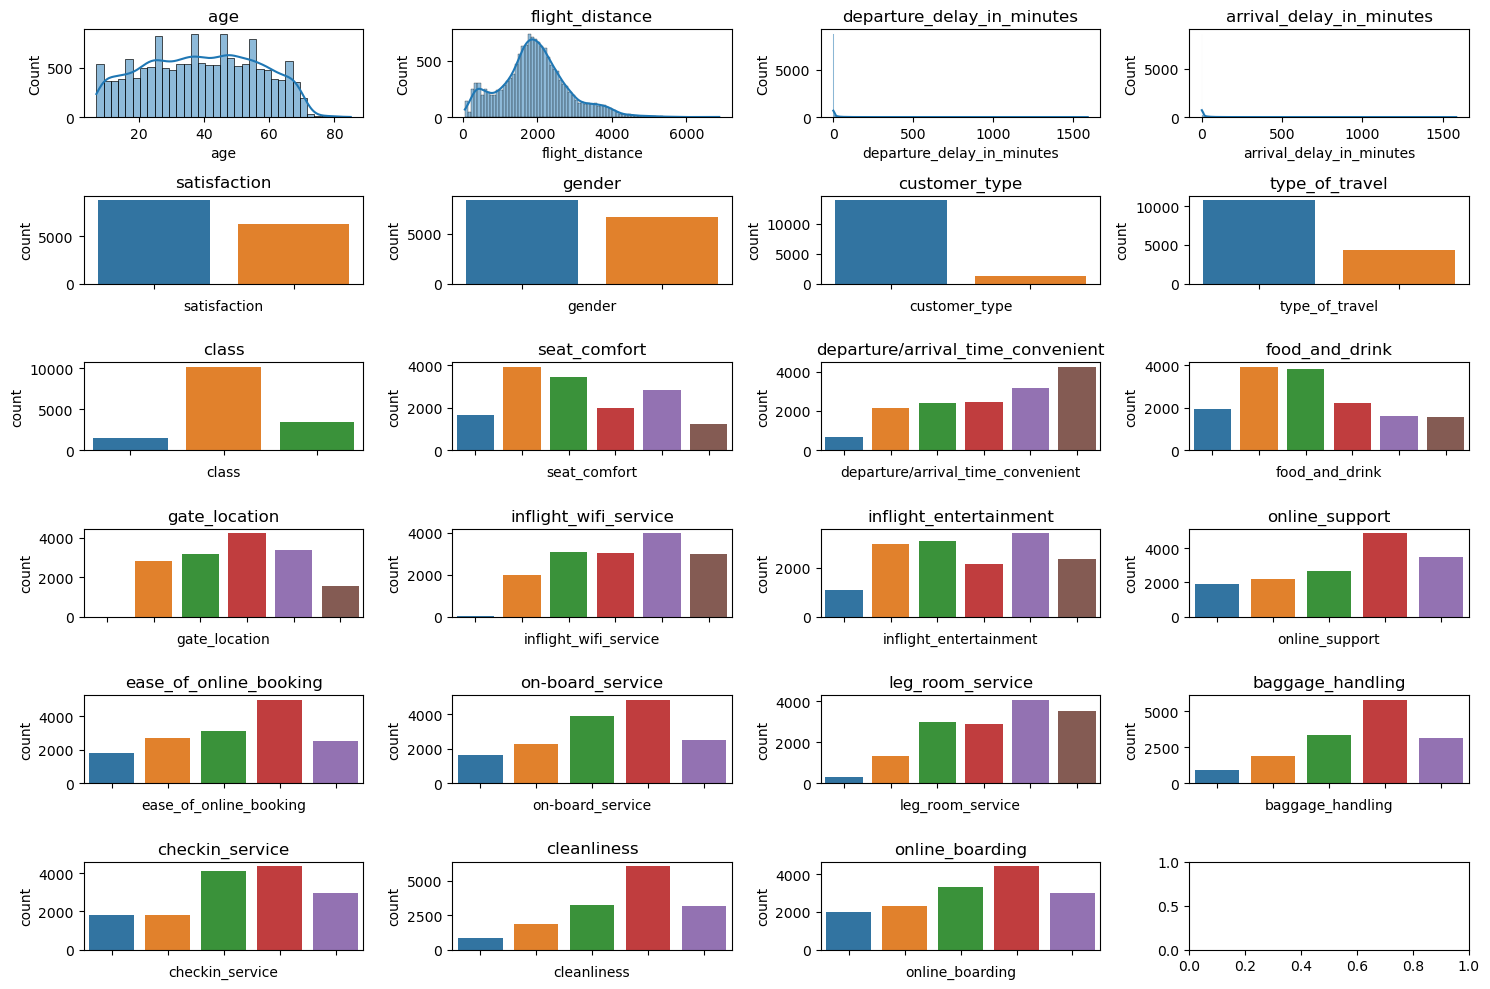

In [12]:
# Plotting subplots
num_rows = 6
num_cols = (len(numerical_columns) + len(categorical_columns) + num_rows - 1) // num_rows
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(df[column], ax=axes[row][col], kde=True)
    axes[row][col].set_title(column)

for i, column in enumerate(categorical_columns):
    row = (i + len(numerical_columns)) // num_cols
    col = (i + len(numerical_columns)) % num_cols
    sns.countplot(data=df, x=column, ax=axes[row][col])
    axes[row][col].set_title(column)
    axes[row][col].set_xticklabels([])  # Remove x-axis labels

plt.tight_layout()
plt.show()


## Bivariate

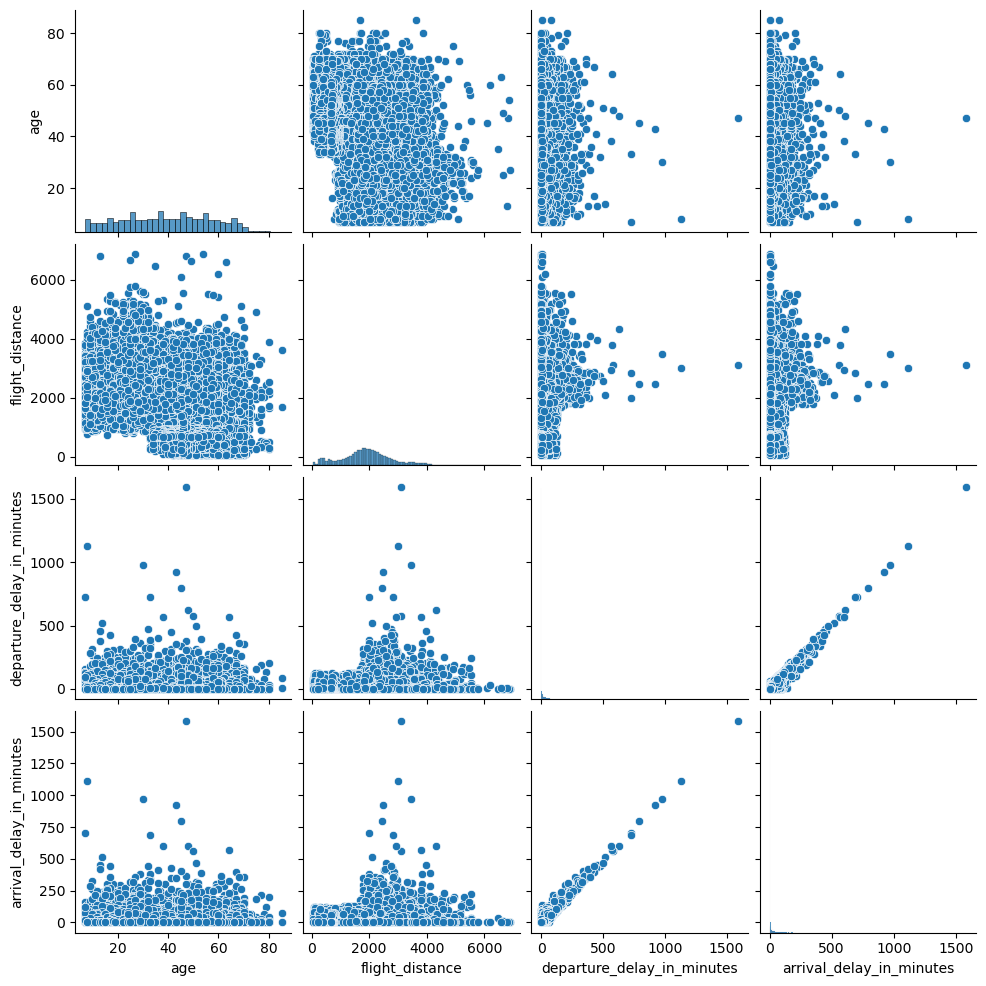

In [13]:
sns.pairplot(df[numerical_columns])